In [10]:
%env JAX_DISABLE_JIT=False

try:
  import dlfb
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import dlfb

from dlfb.utils.display import display

env: JAX_DISABLE_JIT=False


In [1]:
import py3Dmol
import requests

def fetch_protein_structure(pdb_id: str) -> str:
    """grab a PDB protein structure from the PCSB data bank"""
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    return response.text

# the protein data bank (PDB) is the main database of protein structures.
# each structure has a unique 4-character PDB ID. Below are a few examples.
protein_to_pdb = {
    "insulin":"3I40",
    "collagen":"1BKV",
    "proteasome":"1YAR"
}

protein = "collagen"
pdb_structure = fetch_protein_structure(pdb_id=protein_to_pdb[protein])

pdbview = py3Dmol.view(width=400, height=300)
pdbview.addModel(pdb_structure, "pdb")
pdbview.setStyle({"cartoon": {"color" : "spectrum"}})
pdbview.zoomTo()
pdbview.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
from dlfb.utils.display import print_short_dict
amino_acids = [ "R", "H", "K", "D", "E", "S", "T", "N", "Q", "G", "P", "C", "A", "V", "I", "L", "M", "F", "Y", "W"]

amino_acid_to_index = {
    amino_acid: index for index, amino_acid in enumerate(amino_acids)
}

print_short_dict(amino_acid_to_index)

{'R': 0, 'H': 1, 'K': 2, 'D': 3, 'E': 4, 'S': 5, 'T': 6, 'N': 7, 'Q': 8, 'G': 9}
…(+10 more entries)


In [3]:
# methionine, alanine, leucine, tryptophan, methionine
tiny_protein = ["M", "A", "L", "W", "M"]

tiny_protein_indices = [amino_acid_to_index[amino_acid] for amino_acid in tiny_protein]

tiny_protein_indices

[16, 12, 15, 19, 16]

INFO:2026-01-21 22:18:42,878:jax._src.xla_bridge:810: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
2026-01-21 22:18:42.878 INFO jax._src.xla_bridge xla_bridge - backends: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


[Text(0.5, 146.32222222222222, 'Amino Acid Index'),
 Text(50.722222222222214, 0.5, 'Protein Sequence')]

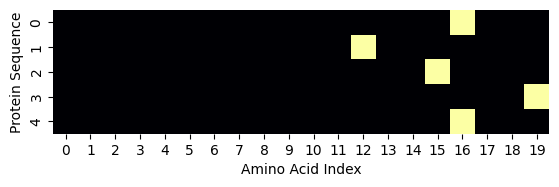

In [4]:
import jax

one_hot_encoded_sequence = jax.nn.one_hot(
    x=tiny_protein_indices, num_classes=len(amino_acids)
)

import seaborn as sns
fig = sns.heatmap(one_hot_encoded_sequence, square=True, cbar=False, cmap="inferno")
fig.set(xlabel="Amino Acid Index", ylabel="Protein Sequence")

In [27]:
from transformers import AutoTokenizer, EsmModel

#model checkpoint name taken from this github readme: etc
model_checkpoint = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

vocab_to_index = tokenizer.get_vocab()
print_short_dict(vocab_to_index)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7,
'S': 8, 'E': 9}
…(+23 more entries)


In [28]:
tokenized_tiny_protein = tokenizer("MALWM")["input_ids"]
tokenized_tiny_protein[1:-1]

[20, 5, 4, 22, 20]

In [29]:
token_embeddings = model.get_input_embeddings().weight.detach().numpy()
token_embeddings.shape

(33, 1280)

In [30]:
import pandas as pd
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(token_embeddings)
embeddings_tsne_df = pd.DataFrame(embeddings_tsne, columns=["first_dim", "second_dim"])
embeddings_tsne_df.shape

(33, 2)

Text(0, 0.5, 'Second Dimentsion')

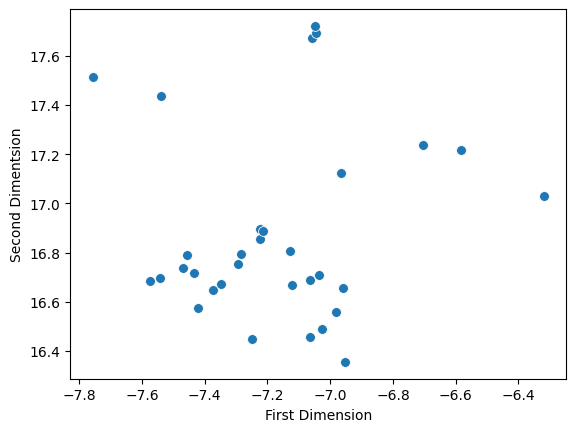

In [32]:
import seaborn as sns
fig = sns.scatterplot(
    data=embeddings_tsne_df, x="first_dim", y="second_dim", s=50
)
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimentsion")

# let's color the t-SNE projection by amino acid properties reveals clear clusters of amino acids with similar biochemical roles that tend to group together in embedding space, reflecting the model's ability to capture meaningful biological structure. technical non-amino acid tokens also group together in this latent space.

([Text(-7.667293499320025, 17.558232250667757, '<cls>'),
  Text(-6.948289268986593, 17.627360400699434, '<pad>'),
  Text(-7.442401329433967, 17.48158353850955, '<eos>'),
  Text(-6.648687553747047, 17.665500141325452, '<unk>'),
  Text(-7.102059385961583, 16.7058139528547, 'L'),
  Text(-7.258246379345656, 16.83220641953605, 'A'),
  Text(-7.461588746561639, 16.766359420049756, 'G'),
  Text(-7.095453001719809, 16.818035023553033, 'V'),
  Text(-7.27150278733142, 16.74304701033093, 'S'),
  Text(-7.443429991380581, 16.85247370174953, 'E'),
  Text(-7.3239547959631, 16.628323804764523, 'R'),
  Text(-7.0459317436598, 16.66430031685602, 'T'),
  Text(-7.0213070773309285, 16.75936467306955, 'I'),
  Text(-7.570500700856529, 16.743477560224985, 'D'),
  Text(-7.51456224498369, 16.75858637264797, 'P'),
  Text(-7.410663825129309, 16.72172977810814, 'K'),
  Text(-7.323422002798368, 16.73803147815523, 'Q'),
  Text(-7.394112087947226, 16.565315995897567, 'N'),
  Text(-7.003716801200062, 16.518865528560823,

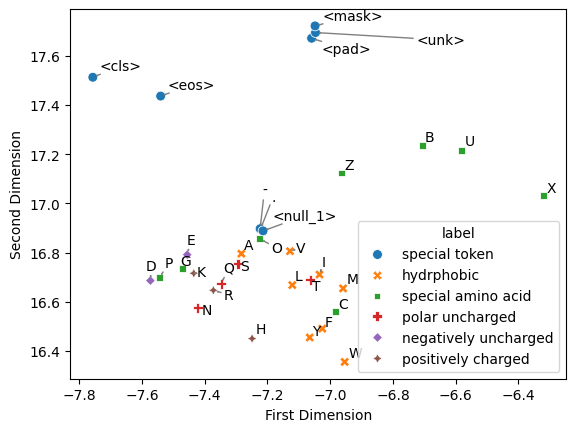

In [14]:
from adjustText import adjust_text

embeddings_tsne_df["token"] = list(vocab_to_index.keys())

token_annotation = {
    "hydrphobic": ["A", "F", "I", "L", "M", "V", "W", "Y"],
    "polar uncharged": ["N", "Q", "S", "T"],
    "negatively uncharged":["D", "E"],
    "positively charged":["H", "K", "R"],
    "special amino acid":["B", "C", "G", "O", "P", "U", "X", "Z"],
    "special token" : [
        "-",
        ".",
        "<cls>",
        "<eos>",
        "<mask>",
        "<null_1>",
        "<pad>",
        "<unk>",
    ],
}

embeddings_tsne_df["label"] = embeddings_tsne_df["token"].map({t: label for label, tokens in token_annotation.items() for t in tokens})

fig = sns.scatterplot(
    data=embeddings_tsne_df,
    x="first_dim",
    y="second_dim",
    hue="label",
    style="label",
    s=50,
)
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimension")
texts = [
    fig.text(point["first_dim"], point["second_dim"], point["token"]) 
    for _, point in embeddings_tsne_df.iterrows()
]
adjust_text(
    texts, expand=(1.5, 1.5), arrowprops=dict(arrowstyle="->", color="grey")
)

In [33]:
insulin_sequence =  (
    "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG"
    "GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
) 

In [34]:
masked_insulin_sequence = (
    "MALWMRLLPLLALLALWGPDPAAAFVNQH<mask>CGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG"
    "GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
) #maksed insulin's 29th seq. L
masked_inputs = tokenizer(masked_insulin_sequence)["input_ids"]
assert masked_inputs[30] == vocab_to_index["<mask>"]

In [16]:
from transformers import EsmForMaskedLM

model_checkpoint = "facebook/esm2_t30_150M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
masked_lm_model = EsmForMaskedLM.from_pretrained(model_checkpoint)

import matplotlib.pyplot as plt

model_outputs = masked_lm_model(
    **tokenizer(text=masked_insulin_sequence, return_tensors="pt")
)

c:\Users\justc\anaconda3\envs\dl4b\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\justc\.cache\huggingface\hub\models--facebook--esm2_t30_150M_UR50D. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Text(0.5, 1.0, 'Model Probabilities for the Masked Amino Acid')

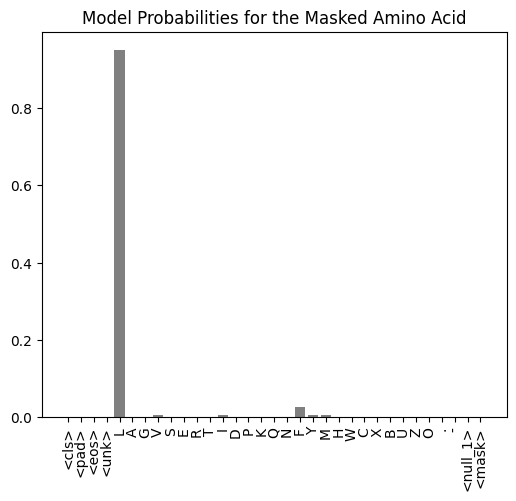

In [22]:
model_preds = model_outputs.logits
mask_preds = model_preds[0, 30].detach().numpy()
mask_probs = jax.nn.softmax(mask_preds)
letters = list(vocab_to_index.keys())
fig, ax = plt.subplots(figsize=(6,5))
plt.bar(letters, mask_probs, color="grey")
plt.xticks(rotation=90)
plt.title("Model Probabilities for the Masked Amino Acid")

In [25]:
from matplotlib.figure import Figure
from transformers import PreTrainedModel, PreTrainedTokenizer
import jax
class MaskPredictor:
    """predict masked amino acids using a protein language model"""
    def __init__(self, tokenizer: PreTrainedTokenizer, model: PreTrainedModel):
        """initialize with a tokenizer and pretrained model"""
        self.tokenizer = tokenizer
        self.model = model

    def plot_predictions(self, sequence: str, mask_index: int):
        """plot predicted probabilities for the masked amino acid"""
        mask_probs = self.predict(sequence, mask_index) # type: ignore
        fig, _ = plt.subplots(figsize=(6, 4))
        plt.xticks(rotation=90)
        plt.bar(list(self.tokenizer.get_vocab().keys()), mask_probs, color="grey")
        
        plt.title("Model Probabilities for the masked amino acid\n"
                  f"at Index={mask_index} (True Amino Acid = {sequence[mask_index]}).")
        return fig
    
    def predict(self, sequence:str, mask_index: int):
        """return model probabilities for masked amino acid at a position"""
        masked_sequence = self.mask_sequence(sequence, mask_index)
        masked_inputs = self.tokenizer(masked_sequence, return_tensors="pt")
        model_outputs = self.model(**masked_inputs)
        mask_preds = model_outputs.logits[0, mask_index + 1].detach().numpy()
        mask_probs = jax.nn.softmax(mask_preds)
        return mask_probs
    
    @staticmethod
    def mask_sequence(sequence: str, mask_index: int) :
        """insert mask token at specified index in the input sequence"""
        if mask_index < 0 or mask_index > len(sequence):
            raise ValueError("mask index outside of sequence range.")
        return f"{sequence[0:mask_index]}<mask>{sequence[(mask_index + 1):]}"



c:\Users\justc\anaconda3\envs\dl4b\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


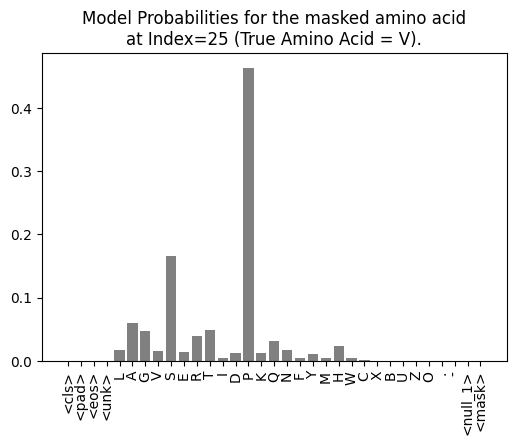

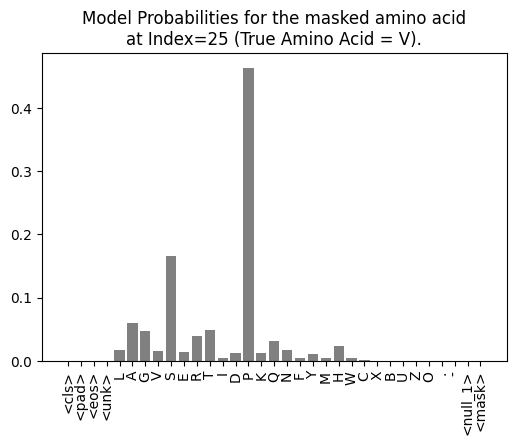

In [32]:
MaskPredictor(tokenizer, model=masked_lm_model).plot_predictions(sequence=insulin_sequence, mask_index=25)

# Extracellular versus membrane protein embeddings

In [18]:
import pandas as pd
from dlfb.utils.context import assets

protein_df = pd.read_csv(r"C:\Users\justc\Documents\ml-study-notes\ml-study-notes\dlfb-clone\assets\proteins\datasets\sequence_df_cco.csv")
protein_df = protein_df[~protein_df["term"].isin(["GO:0005575", "GO:0110165"])]
num_proteins = protein_df["EntryID"].nunique()
print(protein_df)

       EntryID                                           Sequence  taxonomyID  \
0       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
1       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
2       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
3       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
5       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
...        ...                                                ...         ...   
337549  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   
337550  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   
337551  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   
337552  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   
337553  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   

              term aspect  

In [21]:
# filter protein dataframe to proteins with a single location
num_locations = protein_df.groupby("EntryID")["term"].nunique()
proteins_one_location = num_locations[num_locations == 1].index

In [23]:
protein_df = protein_df[protein_df["EntryID"].isin(proteins_one_location)]
go_function_examples = {
    "extracellular" : "GO:0005576",
    "membrane": "GO:0016020",
}

sequences_by_function = {}
min_length = 100
max_length = 150
num_samples = 20

for function, go_term in go_function_examples.items():
    proteins_with_function = protein_df[
        (protein_df["term"] == go_term)
        & (protein_df["Length"] >= min_length)
        & (protein_df["Length"] <= max_length)
    ]
    print(
        f"found {len(proteins_with_function)} human proteins\n"
        f"with the molecular function '{function}' ({go_term}).\n"
        f"and {min_length}<=length<={max_length}\n"
        f"sampling {num_samples} proteins at random. \n"
    )
    sequences = list(proteins_with_function.sample(num_samples, random_state=42, replace=True)["Sequence"])
    sequences_by_function[function] = sequences


found 54 human proteins
with the molecular function 'extracellular' (GO:0005576).
and 100<=length<=150
sampling 20 proteins at random. 

found 7 human proteins
with the molecular function 'membrane' (GO:0016020).
and 100<=length<=150
sampling 20 proteins at random. 



In [ ]:
import torch
import numpy as np
from dlfb.proteins.utils import get_device

def get_mean_embeddings(
        sequences: list[str],
        tokenizer: PreTrainedTokenizer,
        model: PreTrainedModel,
        device: torch.device | None = None,
):
    if not device:
        device = get_device()
    
    # tokenize input sequences and pad them to equal length.
    model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")

    #move tokenized inputs to the target device (CPU in my case)
    model_inputs = {k: v.to(device) for k, v in model_inputs.items()}
    
    model = model.to(device) # type: ignore
    model.eval()

    #forward pass without gradient tracking to obtain embeddings
    with torch.no_grad():
        outputs = model(**model_inputs)
        mean_embeddings = outputs.last_hidden_state.mean(dim=1)
    
    return mean_embeddings.detach().cpu().numpy()
    

In [37]:
model_checkpoint = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

c:\Users\justc\anaconda3\envs\dl4b\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\justc\.cache\huggingface\hub\models--facebook--esm2_t6_8M_UR50D. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are